In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import os
import collections
import itertools
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as spio
import tensorflow as tf

In [4]:
% matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [5]:
from six.moves import urllib

In [8]:
print(np.__version__)
print(pd.__version__)
print(sp.__version__)
print(tf.__version__)

1.14.0
0.20.3
0.19.1
1.8.0


In [6]:
# The Stanford street view house numbers dataset is available here:
# http://ufldl.stanford.edu/housenumbers/

URL_TRAIN_PATH = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
URL_TEST_PATH = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

DOWNLOADED_FILENAME_TRAIN = "housenumbers_training.mat"
DOWNLOADED_FILENAME_TEST = "housenumbers_test.mat"

def download_data():
    if not os.path.exists(DOWNLOADED_FILENAME_TRAIN):
        filename, _ = urllib.request.urlretrieve(URL_TRAIN_PATH, DOWNLOADED_FILENAME_TRAIN)

    print('Found and verified file from this path: ', URL_TRAIN_PATH)
    print('Downloaded file: ', DOWNLOADED_FILENAME_TRAIN)

    if not os.path.exists(DOWNLOADED_FILENAME_TEST):
        filename, _ = urllib.request.urlretrieve(URL_TEST_PATH, DOWNLOADED_FILENAME_TEST)

    print('Found and verified file from this path: ', URL_TEST_PATH)
    print('Downloaded file: ', DOWNLOADED_FILENAME_TEST)        

In [7]:
download_data()

Found and verified file from this path:  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Downloaded file:  housenumbers_training.mat
Found and verified file from this path:  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Downloaded file:  housenumbers_test.mat


In [8]:
train_mat = spio.loadmat(DOWNLOADED_FILENAME_TRAIN, squeeze_me=True) 
test_mat = spio.loadmat(DOWNLOADED_FILENAME_TEST, squeeze_me=True)    #load matlab file 

In [9]:
type(train_mat)

dict

In [10]:
train_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [23]:
x_train = train_mat['X']    #extract X and Y
y_train = train_mat['y']

x_test = test_mat['X']
y_test = test_mat['y']

In [24]:
x_train.shape # (height,width,num_channels, number_of_examples)

(32, 32, 3, 73257)

In [25]:
y_train.shape, y_test.shape #26032 test examples

((73257,), (26032,))

In [26]:
x_train = np.transpose(x_train, (3, 0, 1, 2))  # change the shape to using np.transpose to be fed into convNN

In [27]:
x_test = np.transpose(x_test, (3, 0, 1, 2))

In [28]:
x_train.shape

(73257, 32, 32, 3)

In [30]:
x_train[0].shape

(32, 32, 3)

In [31]:
def display_digit(digit):
    plt.imshow(digit, interpolation='nearest')

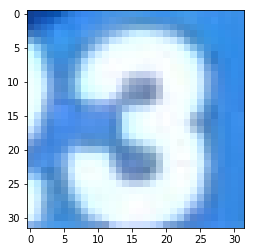

In [34]:
display_digit(x_train[3])

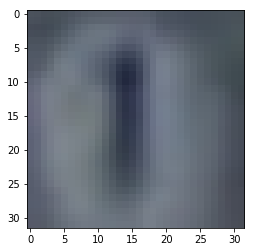

In [35]:
display_digit(x_test[5])

In [36]:
y_train[:10]

array([1, 9, 2, 3, 2, 5, 9, 3, 3, 1], dtype=uint8)

In [37]:
height = 32
width = 32
channels = 3

n_inputs = height * width

In [38]:
conv1_feature_maps = 32
conv1_kernel_size = 3    #initializing variables to be fed into convNN
conv1_stride = 1
conv1_pad = "SAME"

In [39]:
conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = "SAME"

In [40]:
pool3_feature_maps = conv2_feature_maps # feature maps and pooling numbers are same

In [43]:
n_fullyconn1 = 64
n_outputs = 11  # no of classes 10 from 1 to 10

In [44]:
tf.reset_default_graph()

In [45]:
X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")

In [46]:
y = tf.placeholder(tf.int32, shape=[None], name="y")

In [47]:
conv1 = tf.layers.conv2d(X, filters=conv1_feature_maps,
                         kernel_size=conv1_kernel_size,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

In [48]:
conv1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(32)])

In [49]:
conv2 = tf.layers.conv2d(conv1, filters=conv2_feature_maps, 
                         kernel_size=conv2_kernel_size,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

In [50]:
conv2.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(64)])

In [51]:
pool3 = tf.nn.max_pool(conv2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding="VALID")

In [52]:
pool3.shape

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(64)])

In [53]:
pool3_flat = tf.reshape(pool3, shape=[-1, pool3_feature_maps * 8 * 8])

In [54]:
fullyconn1 = tf.layers.dense(pool3_flat, n_fullyconn1,
                             activation=tf.nn.relu, name="fc1")

In [55]:
logits = tf.layers.dense(fullyconn1, n_outputs, name="output")

In [56]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                          labels=y)

In [57]:
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

In [58]:
correct = tf.nn.in_top_k(logits, y, 1)

In [59]:
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [60]:
init = tf.global_variables_initializer()

In [61]:
current_iteration = 0

def get_next_batch(batch_size):
    
    global current_iteration
    
    start_index = (current_iteration * batch_size) % len(y_train)
    end_index = start_index + batch_size

    x_batch = x_train[start_index: end_index]
    y_batch = y_train[start_index: end_index]

    current_iteration = current_iteration + 1

    return x_batch, y_batch

In [62]:
n_epochs = 10
batch_size = 100

In [63]:
with tf.Session() as sess:
    init.run()

    num_examples = len(y_train)
    for epoch in range(n_epochs):
        for iteration in range(num_examples // batch_size):

            X_batch, y_batch = get_next_batch(batch_size)

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        acc_test = accuracy.eval(feed_dict={X: x_test, y: y_test})

        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)        

0 Train accuracy: 0.75 Test accuracy: 0.77412415
1 Train accuracy: 0.88 Test accuracy: 0.8040873
2 Train accuracy: 0.88 Test accuracy: 0.8146128
3 Train accuracy: 0.82 Test accuracy: 0.82471573
4 Train accuracy: 0.88 Test accuracy: 0.83043945
5 Train accuracy: 0.87 Test accuracy: 0.83197606
6 Train accuracy: 0.86 Test accuracy: 0.8227182
7 Train accuracy: 0.86 Test accuracy: 0.83212966
8 Train accuracy: 0.89 Test accuracy: 0.8322833
9 Train accuracy: 0.89 Test accuracy: 0.8365089
